# Clustering algorithms
### KMeans, DBScan, AgglomertiveClustering

https://en.wikipedia.org/wiki/K-means_clustering

https://en.wikipedia.org/wiki/DBSCAN

https://en.wikipedia.org/wiki/Hierarchical_clustering

In [1]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
from sklearn.metrics import pairwise_distances
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque

In [2]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

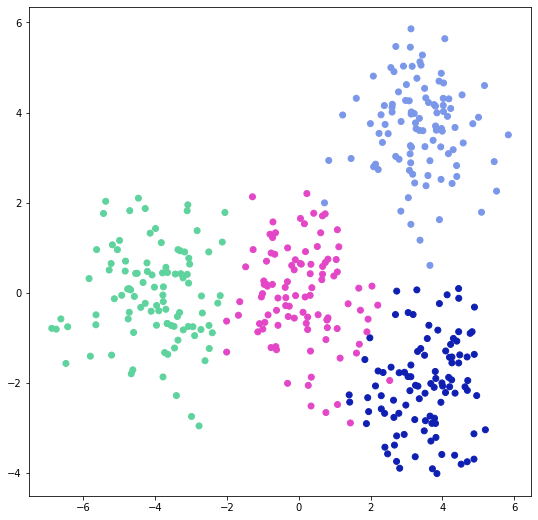

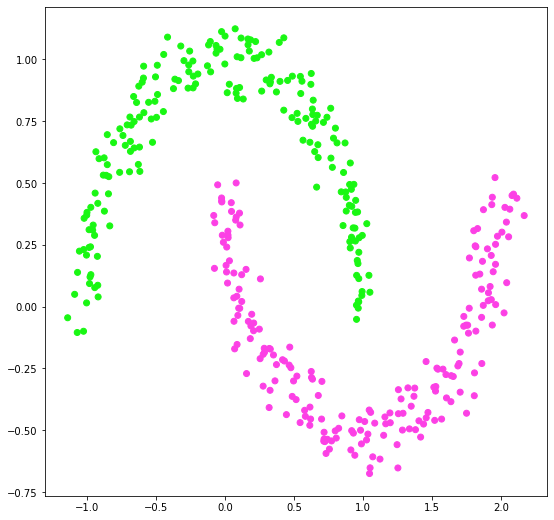

In [15]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)

X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

## KMeans

In [16]:
class KMeans:
    def __init__(self, n_clusters, init='random', max_iter=300):
        self.n_clusters = n_clusters
        self.init_type = init
        self.max_iter = max_iter
        self.centroids = dict()
        
    @staticmethod
    def get_dist(a, b):
        return np.linalg.norm(a-b)
    
    def k_means_pp(self, X, i):
        if len(self.centroids) == self.n_clusters:
            return True
        
        dx2_sum = 0
        dists = []
        for x in X:
            min_dist = 10 ** 10
            for c in self.centroids.values():
                dist = KMeans.get_dist(x, c) ** 2
                if dist < min_dist:
                    min_dist = dist
                    
            dx2_sum += min_dist
            dists.append((x, min_dist))
            
        pos = dx2_sum * np.random.ranf()
        dx2_sum = 0
        for x, dist in dists:
            if dx2_sum > pos:
                self.centroids[i] = x
                break
            dx2_sum += dist
                
        return self.k_means_pp(X, i + 1) 
    
    def reinit_centroids(self, X):
        if self.init_type == 'random': # OK
            x_min = np.min(X_1[:, 0])
            x_max = np.max(X_1[:, 0])
            y_min = np.min(X_1[:, 1])
            y_max = np.max(X_1[:, 1])
            for k in range(0, self.n_clusters):
                self.centroids[k] = np.array([[np.random.uniform(x_min, x_max), np.random.uniform(y_min, y_max)]])
            
        if self.init_type == 'sample': # OK
            ids = np.unique(random.choices(range(0, len(X)), k=self.n_clusters * 5))
            for k in range(0, self.n_clusters):
                self.centroids[k] = X[ids[k]]
                
        if self.init_type == 'k-means++': # OK
            self.centroids[0] = X[np.random.randint(0, len(X))]
            self.k_means_pp(X, 1)
        
    def fit(self, X, y=None):
        self.reinit_centroids(X)
        
        for i in range(0, self.max_iter):
            clusters = {k : list() for k in self.centroids.keys()}
            for x in X:
                min_dist = 10 ** 10
                nearest_cluster = 1
                for c_key, c_vec in self.centroids.items():
                    dist = KMeans.get_dist(c_vec, x)
                    if dist < min_dist:
                        min_dist = dist
                        nearest_cluster = c_key
                        
                clusters[nearest_cluster].append(x)
                
            for c, xs in clusters.items():
                total = np.zeros((1, X.shape[1]))
                for x in xs:
                    total += x

                self.centroids[c] = total / len(xs)
                
    def get_centroids(self):
        res = []
        for i in range(0, len(self.centroids)):
            res.append(self.centroids[i][0])
        return np.array(res)
    
    def predict(self, X):
        clusters = []
        for x in X:
            min_dist = 10 ** 10
            nearest_cluster = 0
            for c_key, c_vec in self.centroids.items():
                dist = KMeans.get_dist(c_vec, x)
                if dist < min_dist:
                    min_dist = dist
                    nearest_cluster = c_key

            clusters.append(nearest_cluster)
            
        return np.array(clusters, dtype='int32')

### synthetic test

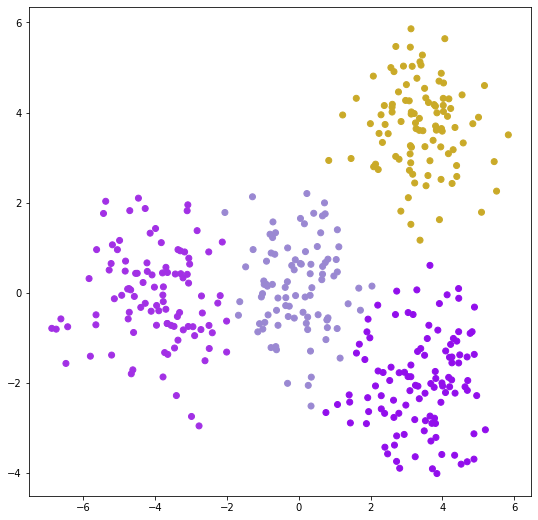

In [17]:
kmeans = KMeans(n_clusters=4, init='k-means++') # 4 выглядит нормально
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

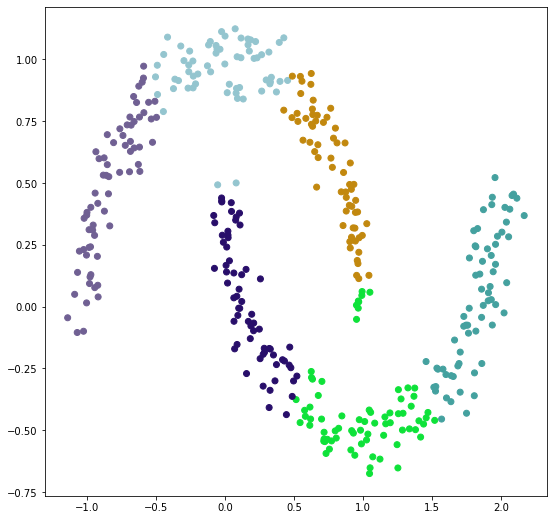

In [18]:
kmeans = KMeans(n_clusters=6, init='sample') # 2-10 плохо - это же k-means, а он со спиралями не работает
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

## DBScan

In [19]:
class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        
    def expand(self, X, neighbours, not_visited, cluster, c, p):
        q = deque(neighbours)
        while len(q) != 0:
            point = q.pop()  
            if point in not_visited:
                not_visited.remove(point)
                nx = set(*self.kdtree.query_radius(X[point:point+1], self.eps, count_only = False))
            else:
                continue

            if len(nx) >= self.min_samples:
                for j in nx:
                    q.append(j)
                    
            if cluster[point] == None:
                cluster[point] = c
                
        return cluster, not_visited
        
    def dbscan_algo(self, X):
        c = 0
        not_visited = [i for i in range(0, len(X))]
        cluster = {i: None for i in range(0, len(X))}
        self.kdtree = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        
        for x in range(0, len(X)):
            if x in not_visited:
                not_visited.remove(x)
            else:
                continue

            neighbours = set(*self.kdtree.query_radius(X[x:x+1], self.eps, count_only = False))
            
            if len(neighbours) < self.min_samples:
                cluster[x] = -1 # Noise
            else:
                cluster[x] = c
                a, b = self.expand(X, neighbours, not_visited, cluster, c, x)
                cluster = a
                not_visited = b
                c += 1
        
        res = []
        for i in range(0, len(X)):
            res.append(cluster[i])
            
        if len(res) < len(X):
            raise ValueError('some points are lost')
        
        return np.array(res)
        
    def fit_predict(self, X, y=None):
        self.kdtree = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        return self.dbscan_algo(X)

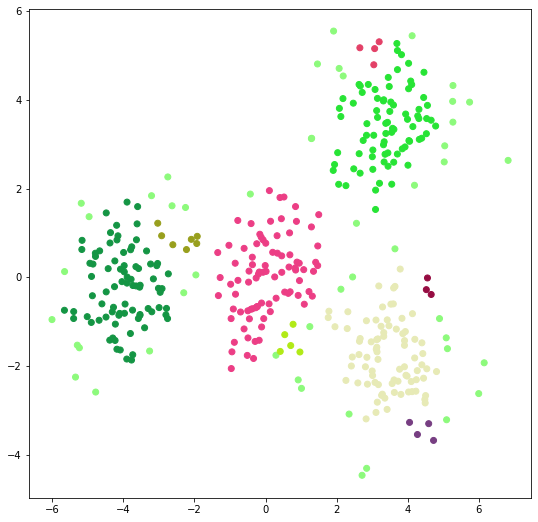

In [18]:
dbscan = DBScan(eps=0.44, min_samples=3) # четыре кластера получилось
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

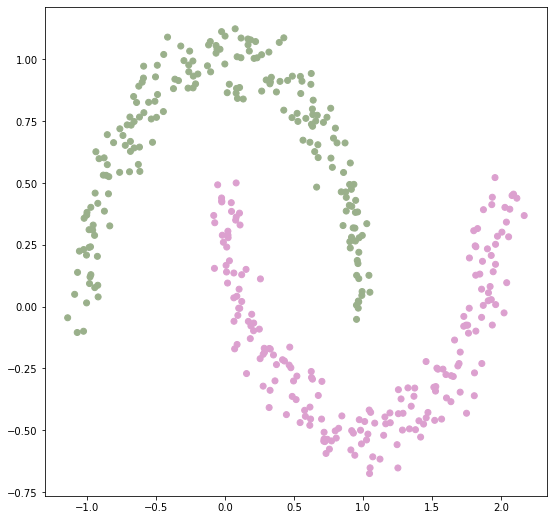

In [20]:
dbscan = DBScan(eps=0.21, min_samples=3)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### AgglomerativeClustering

In [20]:
class AgglomertiveClustering:
    def __init__(self, n_clusters=16, linkage="average"):
        self.n_clusters = n_clusters
        if linkage == 'average':
            self.linkage = AgglomertiveClustering.average_linkage
        if linkage == 'single':
            self.linkage = AgglomertiveClustering.single_linkage
        if linkage == 'complete':
            self.linkage = AgglomertiveClustering.complete_linkage
        
    def average_linkage(self):
        min_dist = 10 ** 10
        to_merge = None
        for i in range(0, len(self.clusters)):
            for j in range(i + 1, len(self.clusters)):
                dist_sum = 0
                for x in self.clusters[i]:
                    for y in self.clusters[j]:
                        dist_sum += self.dists[x][y]
                average = dist_sum / len(self.clusters[i]) / len(self.clusters[j])
                if average < min_dist:
                    min_dist = average
                    to_merge = (i, j)
                    
        return to_merge
        
    def single_linkage(self):
        min_dist = 10 ** 10
        to_merge = None
        for i in range(0, len(self.clusters)):
            for j in range(i + 1, len(self.clusters)):
                md = 10 ** 10
                for x in self.clusters[i]:
                    for y in self.clusters[j]:
                        if self.dists[x][y] < md:
                            md = self.dists[x][y]
                if md < min_dist:
                    min_dist = md
                    to_merge = (i, j)
                    
        return to_merge
        
    def complete_linkage(self):
        min_dist = 10 ** 10
        to_merge = None
        for i in range(0, len(self.clusters)):
            for j in range(i + 1, len(self.clusters)):
                md = 0
                for x in self.clusters[i]:
                    for y in self.clusters[j]:
                        if self.dists[x][y] > md:
                            md = self.dists[x][y]
                if md < min_dist:
                    min_dist = md
                    to_merge = (i, j)
                    
        return to_merge
        
    def fit_predict(self, X, y=None):
        self.dists = pairwise_distances(X, metric='euclidean')
        self.clusters = [[i] for i in range(0, len(X))]
        self.c_count = len(X)
        while self.c_count > self.n_clusters:
            to_merge = self.linkage(self)
            self.clusters[to_merge[0]] += self.clusters[to_merge[1]]
            del self.clusters[to_merge[1]]
            self.c_count -= 1
             
        c_dct = {i : None for i in range(0, len(X))}
        for i in range(0, len(self.clusters)):
            for x in self.clusters[i]:
                c_dct[x] = i

        res = []    
        for i in range(0, len(c_dct)):
            res.append(c_dct[i])
                
        return np.array(res)


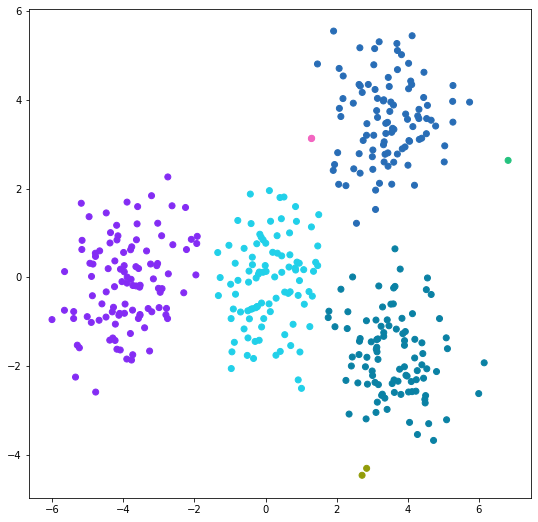

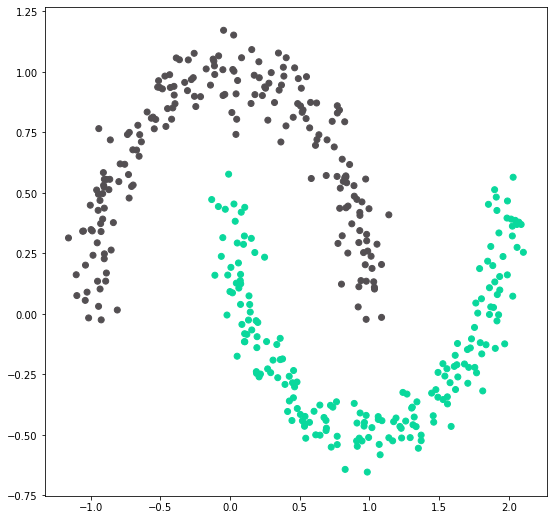

In [21]:
# 30 seconds
agg_clustering = AgglomertiveClustering(n_clusters=7, linkage='average') # average, complete - ok, single - no
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2, linkage='single') # single - ok, others - no
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Image colors clusterization

In [21]:
def read_image(path):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    norm_image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return norm_image

def show_image(image):
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image, path):
    image = np.float32(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) * 255
    cv2.imwrite(path, image)

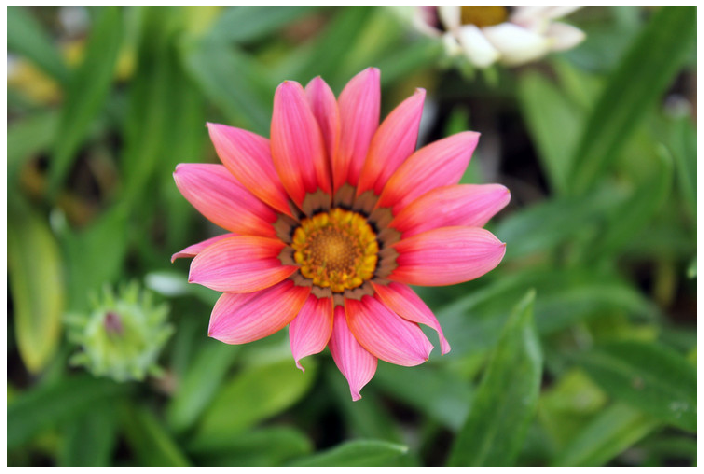

In [55]:
show_image(read_image('./image.jpg'))

In [58]:
save_image(read_image('./image.jpg'), './saved_image.jpg')

In [29]:
def clusterize_image(image, clusters_count=5, **kwargs):
    cluster_colors = [i for i in range(0, clusters_count)] # color of each cluster
    
    x, y, z = image.shape
    image_2d = image.reshape(x * y, z)
    
    kmeans = KMeans(n_clusters=clusters_count, init='k-means++')
    kmeans.fit(image_2d)
    clusters = kmeans.predict(image_2d) # Cluster labels for each pixel in flattened image
    centroids = kmeans.get_centroids()
    
    recolored = centroids[clusters].reshape(x, y, z) # Image with pixel colors assigned to corresponding cluster colors
    
    return recolored

In [34]:
image = read_image('./shaped_image.jpg')
result = clusterize_image(image)

In [57]:
save_image(result, './result_image.jpg')